In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/tiles.zip > /dev/null

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import glob

In [5]:
tile_file_names = sorted(glob.glob('tiles/*.jpg'))
print(tile_file_names[1])

tiles/000001b.jpg


In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import numpy as np
from torchvision.io import read_image

class ChessSquareDataset(Dataset):
    def __init__(self, tile_file_names, transform=None):
        self.img_paths = tile_file_names
        self.transform = transform
        self.piece_to_label = {
            '-':0,
            'r':1,'n':2,'b':3,'q':4,'k':5,'p':6,
            'R':7,'N':8,'B':9,'Q':10,'K':11,'P':12
            }
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = read_image(path)
        label = self.piece_to_label[path[-5:-4]]
        return img, label


In [7]:
from torch.utils.data import DataLoader

train_data = tile_file_names[:44800]
val_data = tile_file_names[44800:57600]
test_data = tile_file_names[57600:]

train_loader = DataLoader(ChessSquareDataset(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(ChessSquareDataset(val_data), batch_size=64, shuffle=True)
test_loader = DataLoader(ChessSquareDataset(test_data), batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 50, 50])
Labels batch shape: torch.Size([64])


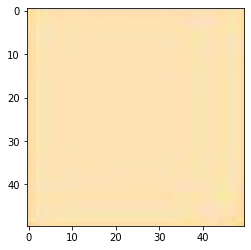

Label: 0


In [8]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
def check_accuracy(loader, model, device=device, verbose=False):
    num_correct, total = 0, 0
    model = model.to(device=device)
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)
            y = y.to(device=device)
            scores = model(X)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            total += preds.size(0)
        percentage = float(num_correct) / total * 100
        if verbose:
            print('Validation Accuracy: {0:.2f}'.format(percentage))
    return percentage

In [11]:
from torch.nn.functional import cross_entropy

def train_model(model, optimizer, epochs=1, device=device, verbose=False):
    model = model.to(device=device)

    for e in range(epochs):
        for t, (X, y) in enumerate(train_loader):
            model.train()
            X = X.to(device=device, dtype=torch.float32)
            y = y.to(device=device)

            scores = model(X)
            loss = cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if verbose and t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(val_loader, model, verbose=verbose)

    return check_accuracy(val_loader, model, verbose=verbose)

In [12]:
from torch import nn

def get_one_block(channel_1, channel_2, dropout, kernel_size):
    return nn.Sequential(
        nn.Conv2d(channel_1, channel_2, kernel_size, padding=kernel_size // 2),
        nn.ReLU(),
        nn.BatchNorm2d(channel_2),
        nn.Dropout2d(p=dropout),
    )

In [14]:
best_hyperparams = {}
best_accuracy = 0

for lr in [1e-5, 1e-4, 1e-3]:
    for wd in [1e-4, 1e-3, 1e-2]:
        for channel_size in [16, 32, 64]:
            for dropout in [0.1, 0.2, 0.5]:
                for kernel_size in [3, 5]:
                    model = nn.Sequential(
                        get_one_block(3, channel_size, dropout, kernel_size),
                        nn.Flatten(),
                        nn.Linear(channel_size*50*50, 128),
                        nn.ReLU(),
                        nn.Linear(128, 13)
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    final_accuracy = train_model(model, optimizer)
                    print(f'Using params lr={lr}, wd={wd}, channel_size={channel_size}, dropout={dropout}, kernel_size={kernel_size}:')
                    print(f'Accuracy = {final_accuracy}')

                    if final_accuracy > best_accuracy:
                        best_hyperparams = {
                            'lr':lr,
                            'wd':wd,
                            'channel_size':channel_size,
                            'dropout':dropout,
                            'kernel_size':kernel_size
                        }
                        best_accuracy = final_accuracy
                        
                    
                    print(f'Best accuracy so far: {best_accuracy}')
                    print()

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.1, kernel_size=3:
Accuracy = 99.4140625
Best accuracy so far: 99.4140625

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.1, kernel_size=5:
Accuracy = 99.703125
Best accuracy so far: 99.703125

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.2, kernel_size=3:
Accuracy = 99.3125
Best accuracy so far: 99.703125

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.2, kernel_size=5:
Accuracy = 99.375
Best accuracy so far: 99.703125

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.5, kernel_size=3:
Accuracy = 99.4140625
Best accuracy so far: 99.703125

Using params lr=1e-05, wd=0.0001, channel_size=16, dropout=0.5, kernel_size=5:
Accuracy = 99.3828125
Best accuracy so far: 99.703125

Using params lr=1e-05, wd=0.0001, channel_size=32, dropout=0.1, kernel_size=3:
Accuracy = 99.8125
Best accuracy so far: 99.8125

Using params lr=1e-05, wd=0.0001, channel_size=32, dropout=0.1, kernel_siz

KeyboardInterrupt: ignored

In [15]:
print(best_hyperparams)

{'lr': 0.0001, 'wd': 0.001, 'channel_size': 32, 'dropout': 0.5, 'kernel_size': 5}


In [18]:
best_model = nn.Sequential(
    get_one_block(3, best_hyperparams['channel_size'], best_hyperparams['dropout'], best_hyperparams['kernel_size']),
    nn.Flatten(),
    nn.Linear(best_hyperparams['channel_size']*50*50, 128),
    nn.ReLU(),
    nn.Linear(128, 13)
)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_hyperparams['lr'], weight_decay=best_hyperparams['wd'])
_ = train_model(best_model, optimizer, epochs=5, verbose=False)

In [20]:
val_acc = check_accuracy(val_loader, best_model, verbose=False)
test_acc = check_accuracy(test_loader, best_model, verbose=False)

print(f'Validation Accuracy: {val_acc}, Test Accuracy: {test_acc}')

Validation Accuracy: 99.8828125, Test Accuracy: 99.9375


In [24]:
torch.save(best_model, 'gdrive/My Drive/best_chess_piece_model.zip')
best_model_scripted = torch.jit.script(best_model)
best_model_scripted.save('gdrive/My Drive/best_model_scripted.pt')